In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential

In [2]:
# Load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)

### Enter your tag as unique id for saving

In [3]:
tag = str("sQNN4-17032023")

0: ──H──RX(0.19)──Rot(0.96,0.94,0.64)─╭●───────╭X─╭●─┤  <Z>
1: ──H──RX(0.18)──Rot(0.52,0.22,0.47)─├●─╭●────│──├X─┤  <Z>
2: ──H──RX(0.73)──Rot(0.97,0.45,0.91)─╰X─├●─╭●─│──│──┤  <Z>
3: ──H──RX(0.20)──Rot(0.78,0.65,0.00)────╰X─├●─├●─│──┤  <Z>
4: ──H──RX(0.07)──Rot(0.75,0.82,0.17)───────╰X─╰●─╰●─┤  <Z>


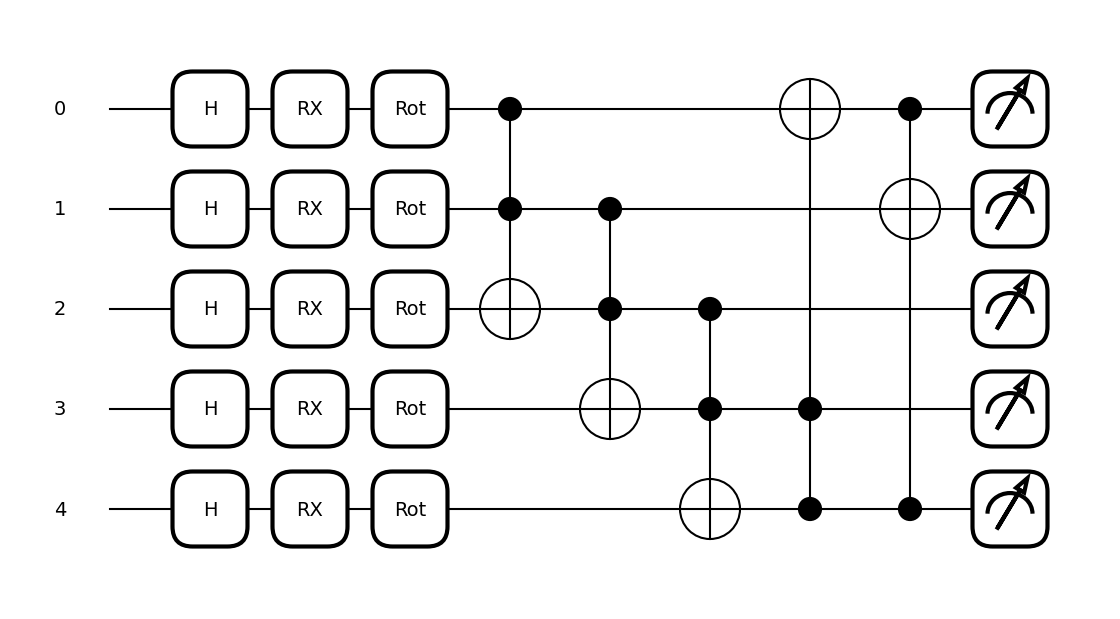

<Figure size 640x480 with 0 Axes>

In [8]:
from pennylane import numpy as np
from customEntanglerLayers import ToffoliEntanglerLayers 
# In a first try, we use as much qubits as we have input params

n_qubits = x_train.shape[1]
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
n_qcParams = n_layers*n_qubits

dev = qml.device("default.qubit", wires=n_qubits)  # number of shots default?

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=inputs, pattern="single")
    qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weights, pattern="single")
    qml.Toffoli(wires=[0,1,2])
    qml.Toffoli(wires=[1,2,3])
    qml.Toffoli(wires=[2,3,4])
    qml.Toffoli(wires=[3,4,0])
    qml.Toffoli(wires=[4,0,1])
    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(qnode)(x_train[0,:],np.random.rand(n_qubits,3)))
fig, ax = qml.draw_mpl(qnode)(x_train[0,:],np.random.rand(n_qubits,3, requires_grad=True))
plt.show()
plt.savefig("archive/Qnode-"+tag+".png")

In [4]:
#Create a simple ANN
clear_session()
layer_0 = Input(shape=(x_train.shape[1],))
layer_1 = Dense(5, activation="relu")
layer_2 = Dense(5, activation="linear")
ann = Sequential([layer_0, layer_1, qlayer, layer_2])
print(f"Params in the quantum layer to train: {n_qcParams}")
ann.summary()

plot_model(ann)

Params in the quantum layer to train: 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 0 (unused)
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [5]:
#Training
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=5, patience=3)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.2, momentum=0.5)

ann.compile(optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

ann_history = ann.fit(x_train, y_train, epochs=20, batch_size=25, validation_split=0.25, callbacks=[LearningRateScheduler, EarlyStopping])

Epoch 1/50
31/31 [==============================] - 349s 11s/step - loss: 13693.3535 - mean_squared_error: 13693.3535 - mean_absolute_error: 116.6365 - val_loss: 11167.0479 - val_mean_squared_error: 11167.0479 - val_mean_absolute_error: 105.3980
Epoch 2/50
31/31 [==============================] - 350s 11s/step - loss: 8268.1660 - mean_squared_error: 8268.1660 - mean_absolute_error: 90.2764 - val_loss: 6973.1855 - val_mean_squared_error: 6973.1855 - val_mean_absolute_error: 83.2071
Epoch 3/50
31/31 [==============================] - 353s 11s/step - loss: 4157.2896 - mean_squared_error: 4157.2896 - mean_absolute_error: 63.5639 - val_loss: 2152.0286 - val_mean_squared_error: 2152.0286 - val_mean_absolute_error: 45.9310
Epoch 4/50
31/31 [==============================] - 400s 13s/step - loss: 1513.2905 - mean_squared_error: 1513.2905 - mean_absolute_error: 35.5502 - val_loss: 195.9398 - val_mean_squared_error: 195.9398 - val_mean_absolute_error: 12.4907
Epoch 5/50
31/31 [==================

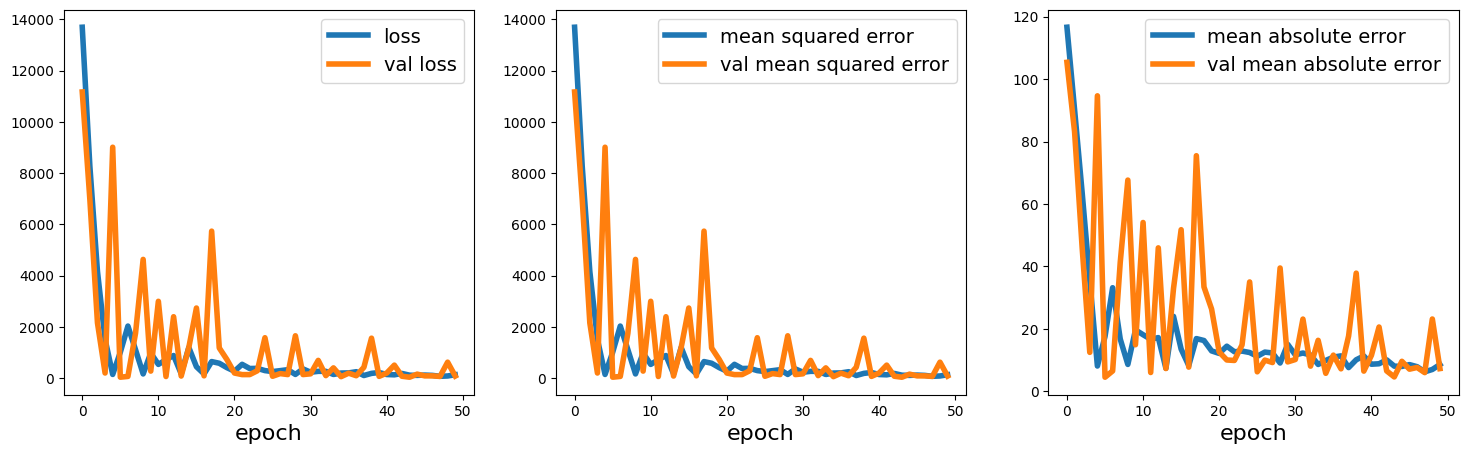

In [6]:
import numpy as np
def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(ann_history)
plt.savefig("archive/history-toffoli-16032023.png")

In [ ]:
fig = plt.figure()
plt.plot(ann_history.history['loss'], lw=4, label='loss')
plt.plot(ann_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(ann_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [7]:
evaluation = ann.evaluate(x_test[:-1], y_test[:-1])

16/16 [==============================] - 78s 5s/step - loss: 79.9819 - mean_squared_error: 79.9819 - mean_absolute_error: 7.6579


In [8]:
ann.save("archive/model-"+tag+".h5")
config = ann.get_config()
np.save("archive/config-"+tag+".npy", config)